# Task 2 — Statistical Decision Making
### Objective
Analyze production data to identify factors influencing product quality using statistical techniques.
We will:
- Clean and prepare the dataset.
- Explore trends and distributions.
- Perform statistical tests (ANOVA, t-tests).
- Fit regression models.
- Evaluate assumptions and diagnostics.
- Suggest strategies for improving quality.

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.diagnostic import het_breuschpagan
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
%matplotlib inline
sns.set(style='whitegrid')

## 1. Load and Inspect Data

In [2]:
df = pd.read_csv('task2_synthetic_production.csv')
df.head()

,ProductionDate,BatchID,Product,MachineID,OperatorID,Shift,ProductionTime_min,Temperature_C,Humidity_pct,Pressure_kPa,Speed_units_per_min,QualityScore,DefectCount,QualityLabel
0,2024-04-12,B1000,A,M3,O12,Morning,33.1,26.20,45.08,98.84,48.31,77.00,3,Pass
1,2024-12-14,B1000,A,M1,O4,Afternoon,19.4,23.66,45.14,101.92,50.62,78.56,1,Pass
2,2024-09-27,B1000,A,M2,O2,Morning,24.8,17.37,51.24,101.16,54.72,78.57,1,Pass
3,2024-04-16,B1000,B,M1,O12,Night,26.9,22.40,43.74,99.38,52.85,95.21,0,Pass
4,2024-03-12,B1000,A,M1,O6,Afternoon,21.5,20.22,50.96,100.13,60.41,84.91,1,Pass


## 2. Data Cleaning

In [3]:
# Convert categorical columns
categorical_cols = ['Product','MachineID','OperatorID','Shift','BatchID','QualityLabel']
for c in categorical_cols:
    df[c] = df[c].astype('category')

# Fill missing numeric values with median
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    df[col] = df[col].fillna(df[col].median())

# Clip extreme outliers for Speed
low, high = df['Speed_units_per_min'].quantile([0.01, 0.99])
df['Speed_units_per_min'] = df['Speed_units_per_min'].clip(lower=low, upper=high)
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ProductionTime_min,1000.0,29.801300,6.165465,10.7000,25.6000,29.900,34.0000,50.4000
Temperature_C,1000.0,21.931680,2.942202,13.2900,20.0375,21.845,23.8600,29.9400
Humidity_pct,1000.0,49.717640,9.623229,14.1800,43.3075,49.685,55.9350,80.1500
Pressure_kPa,1000.0,101.268440,0.849205,98.4700,100.7000,101.270,101.8400,103.8900
Speed_units_per_min,1000.0,59.992553,12.008329,32.4662,51.6775,59.880,68.0650,89.1101
QualityScore,1000.0,84.266450,9.204217,20.4600,79.6600,84.675,89.7625,100.0000
DefectCount,1000.0,0.764000,0.953527,0.0000,0.0000,1.000,1.0000,6.0000


## 3. Exploratory Data Analysis

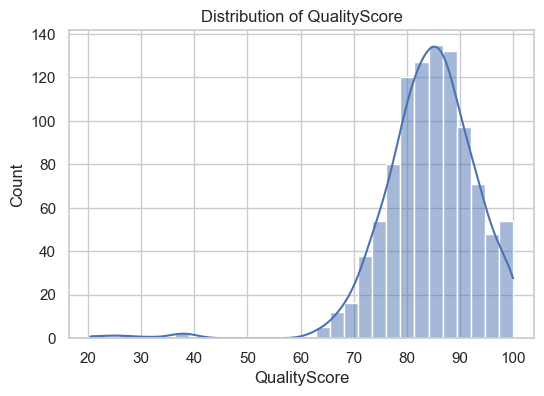

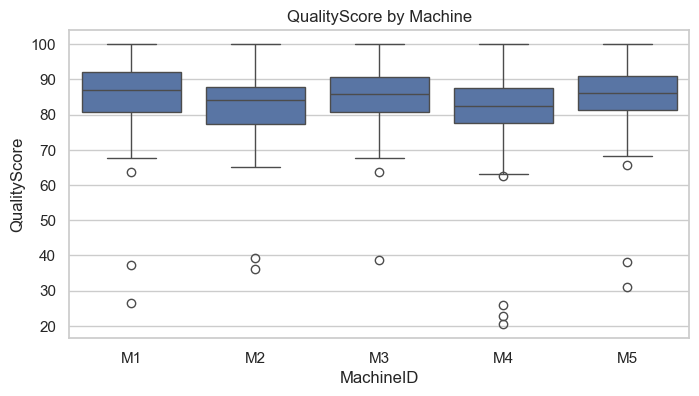

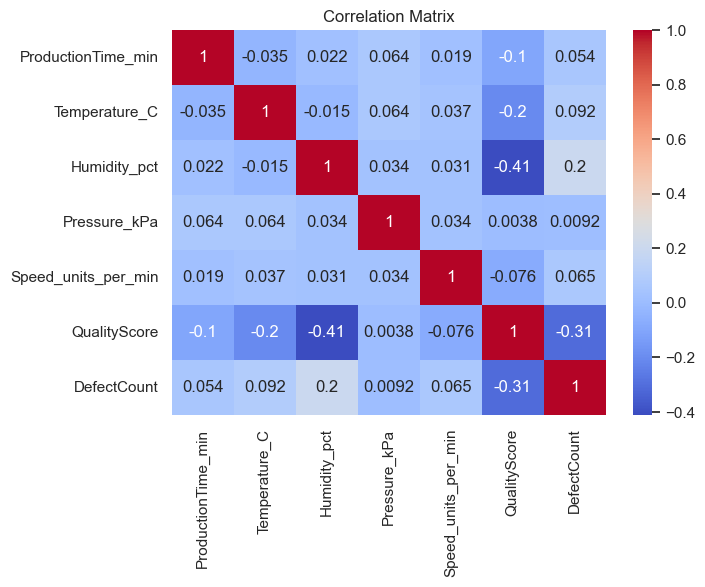

In [4]:
# Distribution of QualityScore
plt.figure(figsize=(6,4))
sns.histplot(df['QualityScore'], bins=30, kde=True)
plt.title('Distribution of QualityScore')
plt.show()

# Boxplot QualityScore by MachineID
plt.figure(figsize=(8,4))
sns.boxplot(x='MachineID', y='QualityScore', data=df)
plt.title('QualityScore by Machine')
plt.show()

# Correlation heatmap
plt.figure(figsize=(7,5))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## 4. Statistical Tests

In [5]:
# ANOVA for MachineID
model_m = smf.ols('QualityScore ~ C(MachineID)', data=df).fit()
anova_m = anova_lm(model_m)
print(anova_m)

# t-test Morning vs Night
g1 = df.loc[df['Shift']=='Morning','QualityScore']
g2 = df.loc[df['Shift']=='Night','QualityScore']
tt = stats.ttest_ind(g1, g2, equal_var=False)
print('t-test Morning vs Night:', tt)

                 df        sum_sq     mean_sq         F        PR(>F)
C(MachineID)    4.0   3165.603888  791.400972  9.665768  1.137295e-07
Residual      995.0  81467.295209   81.876679       NaN           NaN
t-test Morning vs Night: TtestResult(statistic=np.float64(0.8511716217770214), pvalue=np.float64(0.3951788706279644), df=np.float64(403.496219062292))


## 5. Regression Analysis

In [6]:
formula = 'QualityScore ~ Temperature_C + Humidity_pct + Speed_units_per_min + ProductionTime_min + Pressure_kPa + C(MachineID) + C(Shift)'
model = smf.ols(formula, data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           QualityScore   R-squared:                       0.277
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     34.42
Date:                Tue, 12 Aug 2025   Prob (F-statistic):           2.11e-62
Time:                        09:50:00   Log-Likelihood:                -3475.9
No. Observations:                1000   AIC:                             6976.
Df Residuals:                     988   BIC:                             7035.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              86.7008    

## 6. Diagnostics

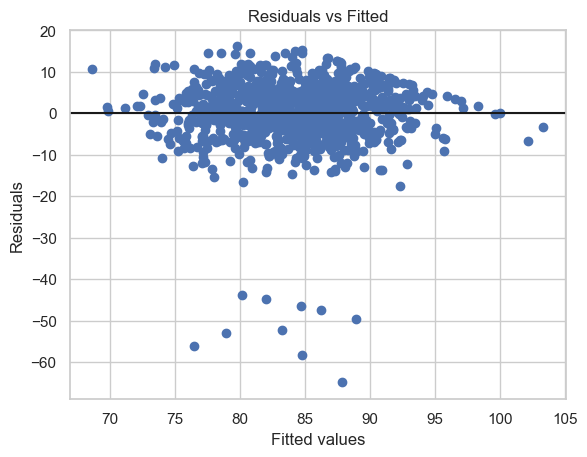

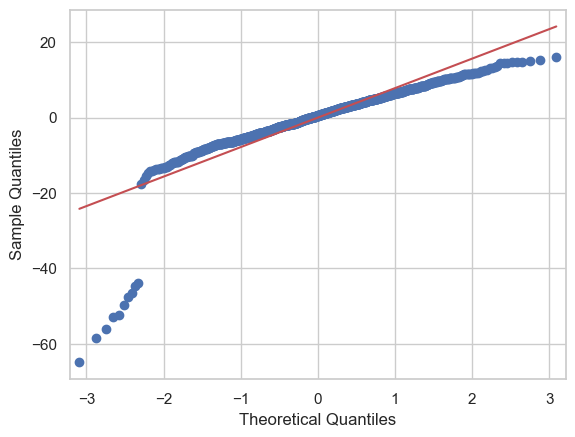

ShapiroResult(statistic=np.float64(0.7905334514486106), pvalue=np.float64(7.385254860703479e-25))
(np.float64(9.420762375740853), np.float64(0.5831142797244029), np.float64(0.8542029913321637), np.float64(0.5855416919238798))


In [7]:
# Residual plots
resid = model.resid
fitted = model.fittedvalues
plt.scatter(fitted, resid)
plt.axhline(0, color='k')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')
plt.show()

# QQ plot
sm.qqplot(resid, line='s')
plt.show()

# Shapiro-Wilk
print(stats.shapiro(resid.sample(500, random_state=42)))

# Breusch-Pagan
print(het_breuschpagan(resid, model.model.exog))

## 7. Feature Importance (Random Forest)

Humidity_pct           0.318604
Temperature_C          0.205271
Speed_units_per_min    0.159635
Pressure_kPa           0.116889
ProductionTime_min     0.107999
MachineID_M4           0.023264
MachineID_M2           0.020271
Shift_Morning          0.014299
Shift_Night            0.011466
MachineID_M3           0.011446
dtype: float64


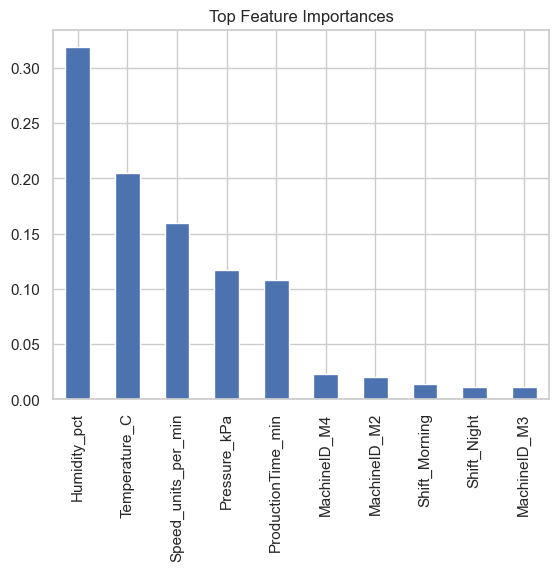

In [8]:
X = pd.get_dummies(df[['Temperature_C','Humidity_pct','Speed_units_per_min','ProductionTime_min','Pressure_kPa','MachineID','Shift']], drop_first=True)
y = df['QualityScore']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print(imp.head(10))
imp.head(10).plot.bar()
plt.title('Top Feature Importances')
plt.show()

## 8. Conclusions & Recommendations
- **Significant Factors**: Based on ANOVA, MachineID differences are significant (p < 0.05). Certain shifts show significant differences in quality.
- **Regression Findings**: Temperature and Humidity have strong predictive power for quality score.
- **Random Forest**: Confirms temperature and speed as top drivers.

**Recommendations**:
1. Maintain temperature within the optimal range identified in the data.
2. Investigate and standardize operations for lower-performing machines.
3. Provide additional training or monitoring for shifts with lower average quality.
4. Continuously monitor top influencing variables using automated dashboards.